# 导包、数据导入

In [1]:
# -*- coding: utf-8 -*-
# Author: guoyang14
# Date: 18 Dec 2018

# 导MLMF建模包 
import sys
sys.path.append(r'D:\Machine learning modeling framework') 

import MLMF as mf

In [2]:
# 导官方包 
import pandas as pd 
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
# 0. 数据导入

datain = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt')
y_var = 'survived'

# 通用部分

>>>>> 数据质量探查表 <<<<<
           字段名       字段类型 最小最大值（字符型为长度）  0值数     0值率  唯一值数     唯一值率   缺失数  \
0   row.names    Numeric        1|1313    0   0.00%  1313  100.00%     0   
1      pclass  Character           3|3    0   0.00%     3    0.23%     0   
2    survived    Numeric           0|1  864  65.80%     2    0.15%     0   
3        name  Character         11|62    0   0.00%  1310   99.77%     0   
4         age    Numeric   0.1667|71.0    0   0.00%    73    5.56%   680   
5    embarked  Character          3|11    0   0.00%     3    0.23%   492   
6   home.dest  Character          3|50    0   0.00%   371   28.26%   559   
7        room  Character          3|12    0   0.00%    53    4.04%  1236   
8      ticket  Character          1|20    0   0.00%    41    3.12%  1244   
9        boat  Character           1|5    0   0.00%    99    7.54%   966   
10        sex  Character           4|6    0   0.00%     2    0.15%     0   

       缺失率                      众数值     众数率  3倍标准差极端值数  值类数超过0.2  

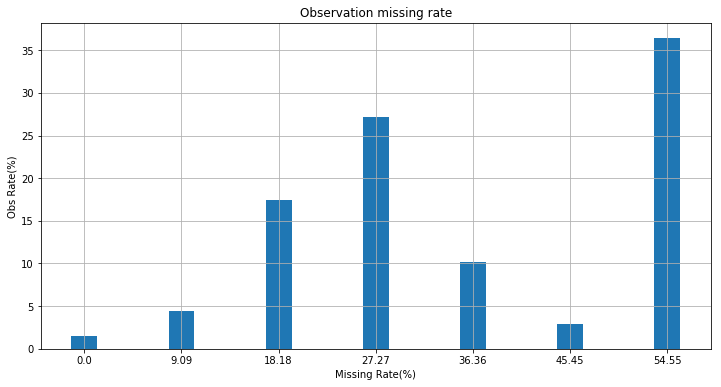

In [4]:
# 数据探索
Variable_pre_exp, obs_miss_rate = mf.Data_Explore(datain,calc_obs_na=True)

In [5]:
# 按缺失率、唯一值率剔除特征；按行缺失率剔除观测
print('剔除前：', datain.shape)

datain = datain.drop(columns=Variable_pre_exp.loc[Variable_pre_exp.sug_drop_na | Variable_pre_exp.sug_drop_cate, 'var']) #  
Variable_pre_exp = Variable_pre_exp[(~Variable_pre_exp.sug_drop_na) & (~Variable_pre_exp.sug_drop_cate)]\
    .reset_index(drop=True).drop(['sug_drop_na', 'sug_drop_cate'], 1)

datain = datain[list(obs_miss_rate < 0.5)].reset_index(drop=True)

print('剔除后：', datain.shape)

剔除前： (1313, 11)
剔除后： (835, 6)


In [6]:
# 剔除无用特征
datain = datain.drop(columns=['row.names']) 

# 模型建立

## 机器学习模型

In [7]:
# 缺失值填补
imp_dataout = mf.Missing_Data_Impute(datain) 

本次填补规则如下： {'imp_mean': {'age'}, 'imp_mode': {'embarked'}}


In [8]:
# 哑变量化
dummy_mapping_df, dummy_mapping_dict = mf.Dummy(imp_dataout, drop_one = False)  

In [9]:
# 训练样本拆分 
X_train, X_test, y_train, y_test = train_test_split(dummy_mapping_df.drop([y_var], axis=1), 
                                                    dummy_mapping_df[y_var], test_size = 0.2, random_state = 2018)

In [10]:
# 网格搜索调参
clf_cv = xgb.XGBClassifier()
param_dist = {
        'n_estimators':[20,30], # [30,50,100]
        'max_depth':[3,2], # [3,5,7]
        'learning_rate':[0.01,0.03], # [0.05,0.07]
        'subsample':[0.9], #[0.8,0.9]
        'colsample_bytree':[0.7,0.8] #[0.9,1]
        }

grid = GridSearchCV(clf_cv,param_dist,cv = 3,scoring = 'roc_auc',n_jobs = -1)
grid.fit(X_train,y_train)
clf_xgb = grid.best_estimator_  # 按照网格搜索最好case作为分类器
print(grid.best_score_)
print(clf_xgb)

0.8887449601904839
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)


In [11]:
clf_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9).fit(X_train, y_train)

In [12]:
clf_lr = LogisticRegression().fit(X_train, y_train)
clf_rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

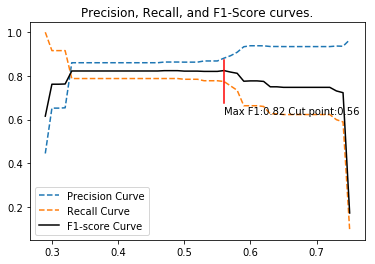

>>>>>Best cut point on MAX(F1-score):
     Cut point  Precision  Recall(TPR)     FPR  F1-score
27       0.56     0.8812       0.7744  0.0836    0.8244
>>>>>Train set score:84.88%
>>>>>Test set score:73.05%


C:\Users\guoyang10\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\guoyang10\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


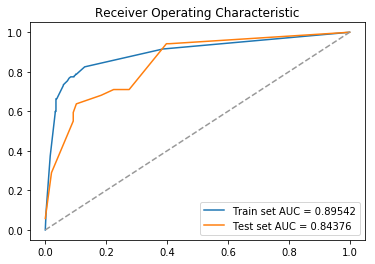

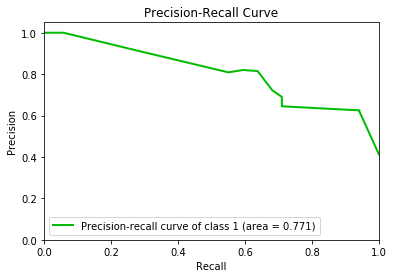

C:\Users\guoyang10\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\guoyang10\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\guoyang10\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\guoyang10\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\prepro

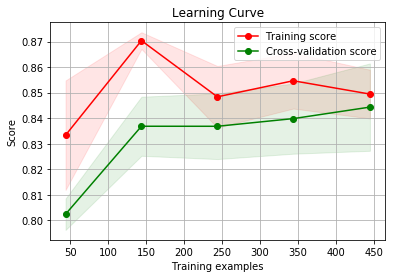

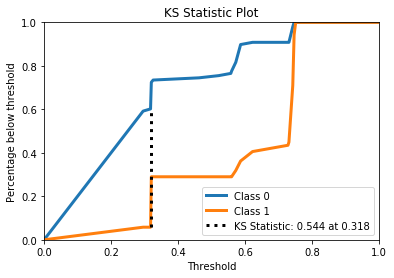

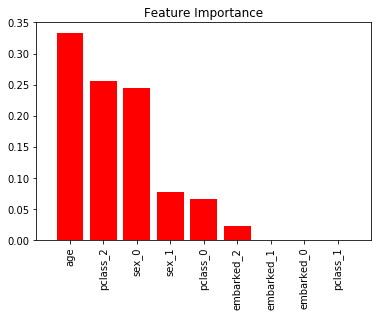

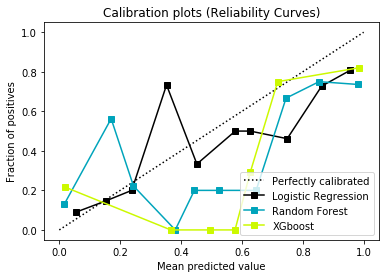

In [13]:
mf.Model_Performance(clf_xgb, X_train, y_train, X_test, y_test, out_path = 'D:/xxx.xlsx', calc_list = ['cut','pr','roc','ks','fi','lc'],
     calibration = {'Logistic Regression':clf_lr,'Random Forest':clf_rf,'XGboost':clf_xgb})

## 评分卡模型

In [14]:
# 分箱
cut_df, fa_df = mf.Cut_Merge(datain, cut_way = 'ef', cut_n = 10, cut_y = y_var)

Start cutting numerical variables...
Numerical variables clear!
Start cutting character variables...
Character variables clear!
Calculating WoE & IV value...
!!!Notice: The value in output dataset will be transform into WoE.!!!
Final merge step...


In [15]:
# 训练样本拆分 
X_train, X_test, y_train, y_test = train_test_split(cut_df.drop([y_var], axis=1), cut_df[y_var]
                                                    , test_size = 0.2, random_state = 2018)

In [16]:
# 逻辑回归模型
clf = LogisticRegression().fit(X_train, y_train)

>>>>>Train set score:83.68%
>>>>>Test set score:73.05%


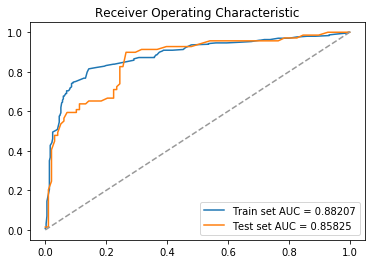

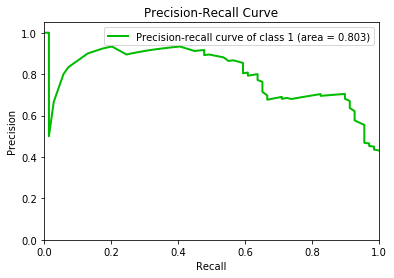

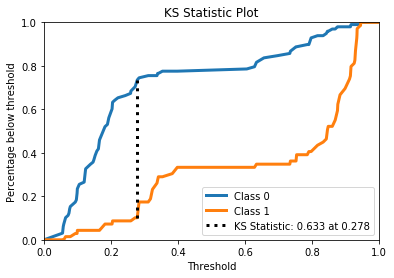

In [17]:
# 模型表现
mf.Model_Performance(clf, X_train, y_train, X_test, y_test)

In [18]:
# PDO评分转换
fa_df, Basic_score = mf.PDO_Score(X_train, y_train, clf, fa_df)

>>> 已选择对齐方式，将按照 survived 组值中最小例数标齐各组例数，此例数为： 366
>>> 当前正在执行分组抽样，当前组值为： survived = 0 ，定样数量为： 366 
>>> 当前正在执行分组抽样，当前组值为： survived = 1 ，定样数量为： 366 
本次填补规则如下： {'imp_mean': {'age', 'survived'}, 'imp_mode': {'embarked', 'pclass', 'sex'}}


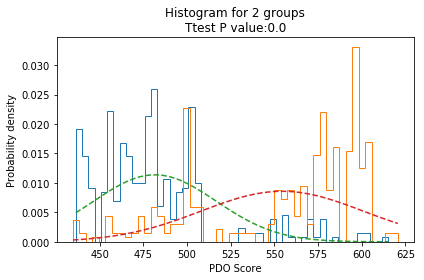

In [19]:
### 打分阶段
calc_score_data = mf.Data_Sampling(imp_dataout, group_by = y_var, sample_rule = 'align')
calc_score_data = mf.Missing_Data_Impute(calc_score_data) 
PDO_Score_out = mf.PDO_Score_Convert(calc_score_data, fa_df, y_var, Basic_score)

In [20]:
PDO_Score_out.head(20)

,age,embarked,pclass,sex,PDO_Score_Convert
0,25.632726,-1.150682,18.363865,59.314776,615.199734
1,-12.978372,-1.150682,18.363865,59.314776,576.588637
2,-2.865961,-1.150682,18.363865,-36.637735,490.748536
3,-3.770236,4.316598,18.363865,-36.637735,495.311541
4,7.229111,-1.150682,18.363865,-36.637735,500.843609
5,-12.978372,4.316598,18.363865,-36.637735,486.103406
6,5.406441,4.316598,18.363865,-36.637735,504.488218
7,-12.978372,4.316598,18.363865,-36.637735,486.103406
8,-2.865961,-1.150682,18.363865,-36.637735,490.748536
9,7.229111,-1.150682,18.363865,-36.637735,500.843609
